In [2]:
import numpy as np
import csv

In [3]:
Earthradius = 6371000
Sunradius = 695508000

In [4]:
kepid = []
koi = []
per = []
adivr = []
delta = []
derror = []

We want our planet sample to match that of Sanchis-Ojeda et al. (2014). They present 106 candidates, but their occurrence rate calculations focus on USP planets around G and K stars, that have effective temperatures between 4100 and 6100 K, log(g) between 4.0 and 4.9, and Kepler magnitudes below 16. The "constrain" function that I define applies these to a CSV, where I just have to enter the column numbers for each of these. The file that I open is Table 2 from  Sanchis-Ojeda et al. (2014), where we also constrain for orbital periods between 4 and 24 hours and radii between 0.84 and 4 Earth radii.

For each of these planets, we record the KIC, KOI, orbital period, transit probability, and transit depth along with its uncertainty.

In [5]:
def constrain(teff, logg, mkep):
    if ((row[teff] != "") and (4100 < float(row[teff]) < 6100)):
        if (((row[logg]) != "") and (4.0  < float(row[logg]) < 4.9)):
            if ((row[mkep] != "") and (float(row[mkep]) < 16)):
                return True

In [6]:
with open('USPCandidates.csv', encoding='latin-1') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        if rownum > 0:
            if constrain(3,6,2):
                if ((row[12] != "") and (4 < (float(row[12])*24) < 24)):
                    if ((row[23] != "") and (.84 < (float(row[23])) < 4)):
                        kepid.append(int(row[0]))
                        koi.append(int(round(float(row[1]))))
                        per.append(float(row[12]))
                        adivr.append(float(row[20]))
                        delta.append(float(row[14]))
                        derror.append(float(row[15]))

        rownum += 1 
        
print(len(kepid))

72


In [7]:
falsepositives = [4929299, 10527135, 5642620, 12170648, 3834322,6750902,7269881,10186945,12115188]

todelete = []
for j in range(0,len(falsepositives)):
    for i in range(0, len(kepid)):
        if kepid[i] == falsepositives[j]:
            todelete.append(i)
            
todelete.reverse()
for k in todelete:
    del kepid[k]
    del koi[k]
    del per[k]
    del adivr[k]
    del delta[k]
    del derror[k]
print(len(kepid))

63


There are 72 planets that fit these criteria. Their paper says they use 69, so we're pretty close.

Now we have to calculate the occurrence rate of USP planets. To do this, we use the formula for Signal to Noise Ratio (SNR) from Howard et al. (2012), which is as follows:

\begin{equation}
    SNR = \frac{\delta}{\sigma_{CDPP}}\sqrt{\frac{T_{0}t}{(6\: hr)P_{orb}}}
\end{equation}

We calculate the SNR for each planet/host star pair.

We use the Kepler catalog to get the host star parameters, and record the Teff, log(g), and Fe/H.  

In [8]:
stars1 = []
snr = np.zeros(len(kepid))
teff= np.zeros(len(kepid))
logg = np.zeros(len(kepid))
feh = np.zeros(len(kepid))

with open('keplerstellar.csv') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        if rownum > 0:
            if constrain(6,8,5):
                if "1" in (str(row[19])[:16]):
                    if ((row[1]) != "") and "q1_q16" in str(row[0]):
                        stars1.append(int(row[1])) 
                        if row[21] != "" and row[22] != "":
                            time = float(row[21])*float(row[22])
                            if row[23] != "":
                                for i in range(len(kepid)):
                                    if int(row[1]) == kepid[i]:
                                        t = (per[i]*24)*(1/adivr[i])*(1/np.pi) # transit duration
                                        snr[i] = ((delta[i]/(float(row[23])))*np.sqrt((t*time)/(per[i]*6)))
                                        teff[i] = (float(row[6]))
                                        logg[i] = (float(row[8]))
                                        feh[i] = (float(row[10]))
                                        
        rownum += 1
print("Total number of stars searched: ", len(stars1))

Total number of stars searched:  105266


The total number of stars searched matches pretty well the number reported in Sanchis-Ojeda et al. (2014).

The Kepler catalog really isn't the best place to get stellar parameters, so I'm replacing the values with ones from Winn et al. (2017) that use the updated CKS parameteters. But not all of the stars I need values for are in that population, so I'll just keep the Kepler values for those.

In [9]:
loggerr = np.zeros(len(kepid))
tefferr = np.zeros(len(kepid))
feherr = np.zeros(len(kepid))

count = 0
with open('ajaa7b7ct1_ascii.csv') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        if rownum > 2:
            for i in range(len(kepid)):
                if int(row[0][3:]) == koi[i]:
                    teff[i] = (float(row[1]))
                    tefferr[i] = np.max([(float(row[3])), (float(row[2]))])
                    logg[i] = (float(row[4]))
                    loggerr[i] = np.max([(float(row[6])), (float(row[5]))])
                    feh[i] = (float(row[7]))
                    feherr[i] = np.max([(float(row[9])), (float(row[8]))])
                    count += 1
                elif int(row[0][3:]) == kepid[i]:
                    teff[i] = (float(row[1]))
                    tefferr[i] = np.max([(float(row[3])), (float(row[2]))])
                    logg[i] = (float(row[4]))
                    loggerr[i] = np.max([(float(row[6])), (float(row[5]))])
                    feh[i] = (float(row[7]))
                    feherr[i] = np.max([(float(row[9])), (float(row[8]))])
                    count +=1
#                 if (int(row[0][3:]) == planets[i].koi):
#                     planets[i].Teff = (float(row[1]))
#                     planets[i].Tefferr = [(float(row[3])), (float(row[2]))]
#                     print(planets[i].Tefferr)
#                     planets[i].logg = (float(row[4]))
#                     planets[i].loggerr = [(float(row[6])), (float(row[5]))]
#                     planets[i].feh = (float(row[7]))
#                     planets[i].feherr = [(float(row[9])), (float(row[8]))]
        rownum += 1

print(count)

43


In [10]:
print(len(tefferr))
print(len(kepid))
print(kepid)

63
63
[2718885, 3112129, 4665571, 8435766, 9642018, 9825174, 10585738, 11187332, 11550689, 1717722, 3444588, 4055304, 4144576, 5040077, 5095635, 5175986, 5513012, 5942808, 5972334, 6129524, 6265792, 6294819, 6310636, 6362874, 6867588, 6934291, 6964929, 6974658, 7102227, 7605093, 7749002, 8278371, 8558011, 8895758, 8947520, 9092504, 9149789, 9221517, 9456281, 9472074, 9473078, 9580167, 10024051, 10028535, 10319385, 10468885, 10647452, 10975146, 11030475, 11401182, 11547505, 11600889, 11752632, 11870545, 11904151, 12265786, 12405333, 5773121, 5980208, 8416523, 9353742, 9475552, 9967771]


One of the main new things we want to do is incorporate new Gaia parallaxes into the radius calculations. We used the gaia-kepler.fun crossmatch database created by Megan Bedell.

In [11]:
from astropy.table import Table
data = Table.read('kepler_dr2_1arcsec.fits', format='fits')

In [12]:
kepid1 = []
parallax2 = np.zeros(len(kepid))
perror2 = np.zeros(len(kepid))

for i in range(len(data['kepid'])):
    for j in range(len(kepid)):
        if kepid[j] == data['kepid'][i]:
            parallax2[j] = (data['parallax'][i])
            perror2[j] = (data['parallax_error'][i])
#         if (planets[j].kepid) == data['kepid'][i]:
#             planets[j].parallax = (data['parallax'][i])
#             planets[j].perror = (data['parallax_error'][i])

In [13]:
parallax3 = parallax2
print(len(parallax3))
print(np.where(parallax3 == 0))
#print(noparallax)
print(kepid[48])
print(len(kepid))
# del kepid[noparallax]
# del koi[noparallax]
# del per[noparallax]
# del teff[noparallax]
# del tefferr[noparallax]
# del logg[noparallax]
# del loggerr[noparallax]
# del feh[noparallax]
# del feherr[noparallax]
# del delta[noparallax]
# del derror[noparallax]
# del parallax2[noparallax]
# del perror2[noparallax]

# print(len(parallax2))

63
(array([48]),)
11030475
63


We need to remove this planet becasue it doesn't have a Gaia parallax.

In [14]:
koi = [koi[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
adivr = [adivr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
per = [per[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
teff = [teff[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
logg = [logg[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
feh = [feh[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
tefferr = [tefferr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
loggerr = [loggerr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
feherr = [feherr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
delta = [delta[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
derror = [derror[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
parallax2 = [parallax2[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
perror2 = [perror2[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
kepid = [i for i in kepid if i != 11030475] # there is no Gaia parallax for this KepID.

# del planets[51]
# print(len(planets))
#print(len(kepid4))
print(len(parallax3))

63


In [15]:
print(len(parallax2))

62


Now, I'm going to record the photometric band magnitudes for each of the host stars. The bands are [Kepler, j, h, k, g, r, i, z].

In [16]:
kepid2 = np.zeros(len(kepid))
kepmag = np.zeros(len(kepid))
jmag = np.zeros(len(kepid))
hmag = np.zeros(len(kepid))
kmag = np.zeros(len(kepid))
gmag = np.zeros(len(kepid))
rmag = np.zeros(len(kepid))
imag = np.zeros(len(kepid))
zmag = np.zeros(len(kepid))

with open('kepler_search.csv') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        if rownum > 1:
            if (int(row[0]) in kepid) and ((int(row[0]) in kepid2) == False):
                for i in range(len(kepid)):
                    if int(row[0]) == kepid[i]:
                        kepid2[i] = int(row[0])
                        kepmag[i] = float(row[37])
                        jmag[i] = float(row[34])
                        hmag[i] = float(row[35])
                        kmag[i] = float(row[36])
                        gmag[i] = float(row[30])
                        rmag[i] = float(row[31])
                        imag[i] = float(row[32])
                        zmag[i] = float(row[33])
#                     if int(row[0]) == planets[i].kepid:
#                         planets[i].photoarray = [float(row[37]), float(row[34]), float(row[35]), float(row[36]),
#                                                   float(row[30]), float(row[31]), float(row[32]), float(row[33])]
        rownum += 1
print(len(kepid2))

62


In [17]:
# for i in range(0,len(planets)):
#     if planets[i].photoarray == 'none':
#         print(planets[i].kepid)
        
# for i in range(0,len(planets)):
#     if planets[i].Tefferr == ['none', 'none']:
#         print(i)
print(tefferr[48])
print(teff[48])
print(logg[48])
print(loggerr[48])
print(feh[48])
print(feherr[48])
print(kepid[48])
print(perror2[48])

64.0
4776.0
4.6
0.03
-0.11
0.04
11401182
0.017492997737671497


All of the stars have recorded photometric band magnitudes. Now we're going to use the isochrones package to interpolate the stellar host radii based on these band magnitudes, as well as log(g), Teff, and Fe/H.

In [18]:
from isochrones import StarModel
from isochrones.mist import MIST_Isochrone

bands = ['J','H','K','Kepler','g','r','i','z']
mist = MIST_Isochrone(bands = bands)
magradii = []
sigma = []
radarray = []
deltaarray = []
fifteen = []
eightyfive = []
num_samples = 1000


In [19]:
file = open('PhotometryPlanetRadiiSamplesRedo3.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, len(kepid2)):
        radiisamples = []
        mags = {'J':(jmag[i],0.05),'H':(hmag[i],0.05),'K':(kmag[i],0.05), 'Kepler':(kepmag[i],0.05), 'g':(gmag[i],0.05), 'r':(rmag[i],0.05), 'i':(imag[i],0.05), 'z':(zmag[i],0.05)}
#         mags = {'J':(planets[i].photoarray[1],0.05),'H':(planets[i].photoarray[2],0.05),'K':(planets[i].photoarray[3],0.05), 
#                 'Kepler':(planets[i].photoarray[0],0.05), 'g':(planets[i].photoarray[4],0.05), 'r':(planets[i].photoarray[5],0.05), 
#                 'i':(planets[i].photoarray[6],0.05), 'z':(planets[i].photoarray[7],0.05)}
#         if (planets[i].Tefferr != ['none', 'none']):
#             model = StarModel(mist, logg = (planets[i].logg,planets[i].loggerr[0]), teff = (planets[i].Teff, planets[i].Tefferr[0]),feh = (planets[i].feh,planets[i].feherr[0]), parallax = (planets[i].parallax,planets[i].perror), **mags)
#         else:
        if (tefferr[i] != 0):
            try:
                model = StarModel(mist, logg = (logg[i],loggerr[i]), teff = (teff[i], tefferr[i]),feh = (feh[i],feherr[i]), parallax = (parallax2[i],perror2[i]), **mags)
            except:
                model = StarModel(mist, parallax = (parallax2[i], perror2[i]), **mags)    
        else:
            model = StarModel(mist, parallax = (parallax2[i], perror2[i]), **mags)
        StarModel.fit_multinest(model,n_live_points=1000, basename=None, verbose=False, refit=True, overwrite=True,test=False)
        magradii.append(model.samples.radius_0_0.quantile(0.5))
        ##planets[i].starrad = model.samples.radius_0_0.quantile(0.5)
        sigma.append(np.std(model.samples.radius_0_0))
        ##planets[i].starraderr = np.std(model.samples.radius_0_0)
        fifteen.append(np.percentile(model.samples.radius_0_0, 15.85))
        eightyfive.append(np.percentile(model.samples.radius_0_0, 84.15))
        radarray = np.random.choice(model.samples.radius_0_0, num_samples) ## star radii
        deltaarray = np.random.normal(delta[i],derror[i], num_samples)
        for j in range(len(radarray)):
            if deltaarray[j] > 0:
                radiisamples.append((radarray[j]*Sunradius*np.sqrt(deltaarray[j]/1000000))/Earthradius)
            else:
                radiisamples.append("nan")
        row = [kepid[i],radiisamples]
        writer.writerow(row)
        print(i)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/isochrones/mist/grid.py:190: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  skip_blank_lines=True, names=column_names)
/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/isochrones/mist/grid.py:195: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = super(MISTModelGrid, self).df_all(phot)
/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['[Fe/H]']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


In [20]:
print(magradii)

[1.3875777648102987, 1.0131363922390486, 0.739911173141945, 0.7563689001524292, 0.8245114919842381, 0.9175790282797902, 0.8940112479022944, 0.9622353525556604, 0.6454731251132491, 0.6715194083314852, 0.6615307349029173, 0.8076676964365077, 0.8607660487020831, 0.9567614073074018, 0.9967523619181015, 0.6634459430748911, 0.8819297393814937, 0.7866322212622845, 0.940858537025169, 0.8235986494171019, 1.3031592325037797, 1.0853172466067713, 1.6438498829733579, 0.8551634386731642, 1.2412888000562794, 0.7369131038863582, 1.0575388628760025, 0.8734720587726919, 0.7270549343494281, 0.7754569640080325, 0.8458873452926217, 1.4223893981222866, 0.8439676096073104, 2.0687109849483822, 0.9602116443128458, 0.9795039748149036, 0.8338214694421917, 0.8030098900746926, 0.6449697080617387, 0.8026004604744015, 0.9845718636030748, 0.7568347589696326, 0.6929807704975276, 0.8776604352068836, 1.0565571615205636, 0.8380443830963782, 0.8256315774120634, 0.7567242222227968, 0.711442008446987, 0.917827762971017, 1.0

In [21]:
print(len(magradii))

62


In [22]:
print(sigma)
raderrup = [value - median for value, median in zip(eightyfive, magradii)]
raderrdown = [median - value for value, median in zip(fifteen, magradii)]
print(raderrdown)

[0.047767444699373614, 0.021246292730175684, 0.012141628231690918, 0.008886625377527452, 0.016700765836177602, 0.0383645824436635, 0.02580117091767631, 0.025194209467848633, 0.00913948599059896, 0.01564052001537285, 0.013843351251034605, 0.011736782617096606, 0.012117192488699998, 0.017884706284181467, 0.02073030712649033, 0.0165579522508496, 0.015213053355518869, 0.013892380120018252, 0.022555050412693553, 0.031493399774113605, 0.028683250219090836, 0.07862907875032868, 0.050476661130100055, 0.013417904333072857, 0.03525084096406114, 0.010025810099705955, 0.02681442993171904, 0.016369049482504082, 0.01220362768440407, 0.021566297325872435, 0.027591968056185585, 0.1503738002611014, 0.013230426661136618, 0.32646588476394184, 0.024921768080583176, 0.0443072886976502, 0.015873364100885374, 0.010881025836989449, 0.010660153773051299, 0.02407844807123212, 0.01641702306325234, 0.014214834274315613, 0.009672368544765293, 0.020677017895717936, 0.01756444385998434, 0.022545139722543194, 0.01954

In [23]:
print(np.max(sigma))

0.32646588476394184


In [24]:
print(kepid)

[2718885, 3112129, 4665571, 8435766, 9642018, 9825174, 10585738, 11187332, 11550689, 1717722, 3444588, 4055304, 4144576, 5040077, 5095635, 5175986, 5513012, 5942808, 5972334, 6129524, 6265792, 6294819, 6310636, 6362874, 6867588, 6934291, 6964929, 6974658, 7102227, 7605093, 7749002, 8278371, 8558011, 8895758, 8947520, 9092504, 9149789, 9221517, 9456281, 9472074, 9473078, 9580167, 10024051, 10028535, 10319385, 10468885, 10647452, 10975146, 11401182, 11547505, 11600889, 11752632, 11870545, 11904151, 12265786, 12405333, 5773121, 5980208, 8416523, 9353742, 9475552, 9967771]


In [25]:
print(koi)

[0, 4144, 2393, 0, 4430, 2880, 3032, 0, 0, 3145, 1202, 2119, 2202, 3065, 2607, 2708, 2668, 2250, 191, 2886, 2753, 2852, 1688, 1128, 2571, 1367, 2756, 2925, 1360, 2817, 4325, 1150, 577, 3106, 2517, 2716, 2874, 2281, 4207, 2735, 2079, 2548, 2409, 2493, 1169, 2589, 4366, 1300, 1428, 1655, 1442, 2492, 1510, 72, 4595, 3009, 4002, 2742, 4441, 3867, 2694, 1875]


Here I'm going to begin re-creating Figure 1, a comparison of my calculated stellar radii to those of Fulton & Petigure (2018).

In [26]:
CKSkoi = []
CKSstarrad = []
CKSerr_up = []
CKSerr_down = []

with open('UpdateFultonPetigura18.csv') as File:
    reader = csv.reader(File, delimiter=',')
    for row in reader:
        r = int(row[0][2:])
        if (r in koi):
            CKSkoi.append(r)
            CKSstarrad.append(float(row[11]))
            CKSerr_up.append(float(row[12]))
            CKSerr_down.append(float(row[13]))

In [27]:
len(CKSerr_down)

39

In [28]:
compare_star_radii = np.zeros(len(CKSkoi))
compare_sigmas = np.zeros(len(CKSkoi))
compare_errup = np.zeros(len(CKSkoi))
compare_errdown = np.zeros(len(CKSkoi))

for i in range(len(koi)):
    for j in range(len(CKSkoi)):
        if (koi[i]) == CKSkoi[j]:
            compare_star_radii[j] = magradii[i]
            compare_sigmas[j] = sigma[i]
            compare_errup[j] = raderrup[i]
            compare_errdown[j] = raderrdown[i]

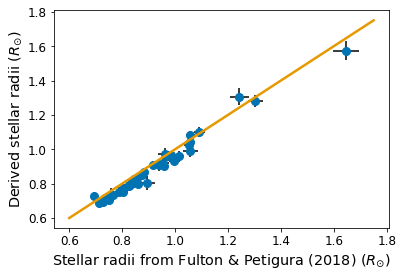

In [29]:
import matplotlib.pyplot as plt

myblue = (0, .45, .70)
mygold = (.9, .6, 0)


x = np.linspace(0.6, 1.75, 50)
plt.plot(compare_star_radii, CKSstarrad, 'o', color = myblue, markersize = 8)
plt.plot(x,x, lw = 2.5, color = mygold)
plt.errorbar(compare_star_radii, CKSstarrad, xerr = [compare_errdown, compare_errup], yerr = [CKSerr_down, CKSerr_up], ls = 'None', ecolor = 'k')
plt.ylabel('Derived stellar radii ($R_{\odot}$)', fontsize = 'x-large')
plt.xlabel('Stellar radii from Fulton & Petigura (2018) ($R_{\odot}$)', fontsize = 'x-large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.show()

Now for Figure 2: Comparing stellar host radii to those used in Sanchis-Ojeda et al. (2014)

In [30]:
SO_radii = np.zeros(len(kepid))
SO_errup = np.zeros(len(kepid))
SO_errdown = np.zeros(len(kepid))

with open('USPCandidates.csv', encoding='latin-1') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        if rownum > 0:
             if row[24] != "":
                for i in range(len(kepid)):
                     if int(row[0]) == kepid[i]:
                        SO_radii[i] = (float(row[9]))
                        SO_errup[i] = (float(row[10]))
                        SO_errdown[i] = (float(row[11]))
        rownum += 1

I'm going to identify the planets that had CKS spectroscopic data vs. the ones that didn't. The ones that didn't don't have an actual error for Teff.

In [31]:
noCKSkepid = []

for i in range(len(tefferr)):
    if tefferr[i] == 0:
        noCKSkepid.append(kepid[i])

noCKSkepidrad = [magradii[kepid.index(i)] for i in noCKSkepid]
radiibuds = [SO_radii[kepid.index(i)] for i in noCKSkepid] ## corresponding radii

otherrad = [magradii[kepid.index(i)] for i in kepid if i not in noCKSkepid]
radiibuds2 = [SO_radii[kepid.index(i)] for i in kepid if i not in noCKSkepid]

print(len(noCKSkepid))
print(len(otherrad))

20
42


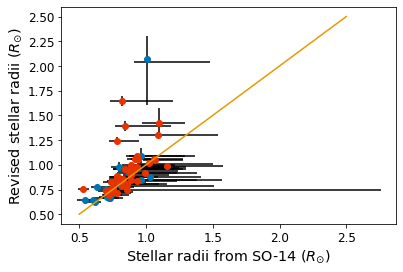

In [56]:
y = np.linspace(0.5, 2.5, 50)

f  = plt.figure()
plt.plot(radiibuds,noCKSkepidrad, 'o', color = myblue)
plt.plot(radiibuds2, otherrad, 'o', color = (0.9, 0.2, 0.0))
plt.errorbar(SO_radii, magradii, yerr = [raderrdown, raderrup], xerr = [SO_errdown, SO_errup], ls = 'None', color = 'k')
plt.plot(y,y, color = mygold)
plt.xlabel("Stellar radii from SO-14 ($R_{\odot}$)", fontsize = 'x-large')
plt.ylabel('Revised stellar radii ($R_{\odot}$)', fontsize = 'x-large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
f.savefig("PosterFig1.pdf", bbox_inches = "tight")
plt.show()
## double check consistent with CKS

In [1]:
SO_errup

NameError: name 'SO_errup' is not defined

In [34]:
print(np.max(SO_errup))
print(SO_radii)

1.9
[0.84 1.02 0.7  0.74 0.79 0.87 0.89 0.9  0.6  0.71 0.72 0.86 0.78 0.84
 0.89 0.73 0.78 0.82 0.87 0.78 1.09 0.96 0.82 0.83 0.78 0.73 0.94 1.03
 0.76 0.75 0.96 1.1  0.89 1.01 0.87 0.8  0.77 0.82 0.54 0.8  1.16 0.7
 0.72 0.79 0.92 0.8  0.74 0.53 0.78 0.99 1.07 0.93 0.74 1.06 0.63 0.86
 0.93 0.62 0.75 0.92 0.86 0.93]


This is a strange value in the Sanchis-Ojeda data, but I checked and it's really there.

y = ((a-d)/(1+(x/c)**b)) + d
a = -0.017876485842042024 b = 5.423514988719173 c = 15.85884523202272 d =  0.9743813210245317


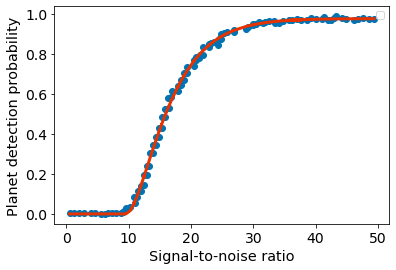

1.8326544798203341 9.656002130909627 4.061402030356385 0.9765401508228847
Power_divergenceResult(statistic=0.10726864454939301, pvalue=1.0)
Power_divergenceResult(statistic=849.0632053690181, pvalue=4.622399627605344e-119)
0.025607780521583547
0.05276580242336572


In [35]:
from scipy.optimize import curve_fit
from scipy import stats

snr = []
prob = []   

with open('SNRProb.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         if rownum > 5:
             snr.append(float(row[0]))
             prob.append(float(row[1]))
         rownum += 1
         

def Logistic(x,a,b,c,d):
    return (((a-d)/(1+(x/c)**b)) + d)

pguess = [0,10,10,1]
par, con = curve_fit(Logistic, snr, prob, p0=pguess)
a  = par[0]
b = par[1]
c = par[2]
d = par[3]
logisticfit = Logistic(snr,0,b,c,d)  

print("y = ((a-d)/(1+(x/c)**b)) + d")
print("a =", a, "b =", b, "c =",c, "d = ", d)

def Gamma(x,a,b,c,d):
    return d*stats.gamma.cdf(x,a,b,c)

pguess2 = [2,5,3,0.95]
par2, con2 = curve_fit(Gamma,snr,prob,p0=pguess2)
a2  = par2[0]
b2 = par2[1]
c2 = par2[2]
d2 = par2[3]
gammafit = Gamma(snr,a2,b2,c2,d2)

plt.plot(snr, prob,'o', color = myblue)
#plt.plot(snr, logisticfit,color = (0.9, 0.2, 0), label = 'Logistic fit', linewidth  = 3)
plt.plot(snr,gammafit,color = (0.9, 0.2, 0), linewidth = 3)
plt.xlabel('Signal-to-noise ratio', fontsize = 'x-large')
plt.ylabel('Planet detection probability', fontsize = 'x-large')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()
plt.show()

print(a2,b2,c2,d2)

gammafit1 = [i for i in gammafit if i != 0]
prob1 = [prob[i] for i in range(0,len(prob)) if gammafit[i] != 0]

print(stats.chisquare(prob1,gammafit1,ddof = 3))
print(stats.chisquare(prob,logisticfit,ddof = 2))

chisq=np.sum((prob-gammafit)**2)
print(chisq)
chisq1=np.sum((prob-logisticfit)**2)
print(chisq1)


So in the paper, I make the claim that my stellar host radii are more exact than those of Sanchis-Ojeda et al. So I need to back up that claim by comparing the size of their uncertainties to mine.

In [36]:
so_dev_up = [i/j for i,j in zip(SO_errup, SO_radii)]
so_dev_down = [i/j for i,j in zip(SO_errdown, SO_radii)]
print("SO Medians")
print(np.median(so_dev_up))
print(np.median(so_dev_down))

print("SO Averages")
print(np.average(so_dev_up))
print(np.average(so_dev_down))

mydev_up = [i/j for i,j in zip(raderrup, magradii)]
mydev_down = [i/j for i,j in zip(raderrdown, magradii)]
print("My medians")
print(np.median(mydev_up))
print(np.median(mydev_down))

print("My averages")
print(np.average(mydev_up))
print(np.average(mydev_down))

SO Medians
0.2805605247465712
0.08333333333333334
SO Averages
0.31602739314926265
0.0877996195121639
My medians
0.020714225875419785
0.019854882589316687
My averages
0.025917263180610908
0.026141306467974947


In [37]:
magradii

[1.3875777648102987,
 1.0131363922390486,
 0.739911173141945,
 0.7563689001524292,
 0.8245114919842381,
 0.9175790282797902,
 0.8940112479022944,
 0.9622353525556604,
 0.6454731251132491,
 0.6715194083314852,
 0.6615307349029173,
 0.8076676964365077,
 0.8607660487020831,
 0.9567614073074018,
 0.9967523619181015,
 0.6634459430748911,
 0.8819297393814937,
 0.7866322212622845,
 0.940858537025169,
 0.8235986494171019,
 1.3031592325037797,
 1.0853172466067713,
 1.6438498829733579,
 0.8551634386731642,
 1.2412888000562794,
 0.7369131038863582,
 1.0575388628760025,
 0.8734720587726919,
 0.7270549343494281,
 0.7754569640080325,
 0.8458873452926217,
 1.4223893981222866,
 0.8439676096073104,
 2.0687109849483822,
 0.9602116443128458,
 0.9795039748149036,
 0.8338214694421917,
 0.8030098900746926,
 0.6449697080617387,
 0.8026004604744015,
 0.9845718636030748,
 0.7568347589696326,
 0.6929807704975276,
 0.8776604352068836,
 1.0565571615205636,
 0.8380443830963782,
 0.8256315774120634,
 0.756724222222

In [38]:
raderrup

[0.05235981547008306,
 0.021114852744240187,
 0.011615648903300024,
 0.009262509667149477,
 0.017200062820549422,
 0.03984036274819602,
 0.028410959930939783,
 0.025576921941117492,
 0.008847665490943735,
 0.015906463967489404,
 0.014168141659077094,
 0.012862709712209819,
 0.013072256031692375,
 0.017722990270979455,
 0.022283826465205547,
 0.016369572678713196,
 0.015125153662286839,
 0.013710598222420711,
 0.02200334254655445,
 0.032434606956291745,
 0.029111562253441248,
 0.08288202840287529,
 0.05224820945190212,
 0.013409601549008165,
 0.03609195026300349,
 0.01027517839120451,
 0.02728761943989033,
 0.0164190768119149,
 0.012531668308977562,
 0.0228381752085266,
 0.029301983673385212,
 0.15420824011501488,
 0.013242322252614458,
 0.26469985684717656,
 0.0251019364106706,
 0.045329594584708865,
 0.016009678723692855,
 0.011062345789184302,
 0.010618815910065083,
 0.02449588333929198,
 0.01713966072855,
 0.014626481187018148,
 0.010237157845164324,
 0.020753979508212006,
 0.017771

In [39]:
adivr = [adivr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
len(adivr)

62

In [40]:
magradii = [1.3889504930655123, 1.012349375037963, 0.739130066228624, 0.7563944422477853, 0.823876769917557, 0.9164067978766238, 0.8932198598519793, 0.9630818319261146, 0.645334043908549, 0.6723896316583433, 0.6613208948593718, 0.8077453135730446, 0.8611528267826624, 0.9571941773487894, 0.9974612017804648, 0.663833475600484, 0.8815187299233647, 0.7860863270798729, 0.9405154527725256, 0.8232563996387668, 1.301991076233905, 1.0859237975652791, 1.6440594685173593, 0.8549196460812376, 1.2417550527165038, 0.7372287294610058, 1.0579153360725728, 0.8735056190406976, 0.7268924696608724, 0.7755122746531886, 0.8457720215772312, 1.4179478695948153, 0.8439629631366707, 2.0433851779610492, 0.9604664331785503, 0.9789717959873322, 0.8337367403725874, 0.8029945549430975, 0.6449459032073522, 0.8032464038285576, 0.9852878243804818, 0.7575851820437182, 0.6931019395085967, 0.8765879129755516, 1.0569271624200833, 0.8371541017237069, 0.8261212548098643, 0.7565852629408361, 0.7114643019298432, 0.9183004522975196, 1.0511264905050017, 1.0913041764526226, 0.6977050593628022, 1.058083718491809, 0.7738518648744791, 0.8026047114435471, 0.8394266383728296, 0.6269374628708656, 0.7640706734127325, 0.955365933295743, 0.7490321865807098, 0.9739648725523049]

In [41]:
len(magradii)

62

In [42]:
a_hope = [i*j for i, j in zip(adivr, magradii)]

In [43]:
print([i*Sunradius/1000 for i in a_hope])

[3313469.7957913587, 2584036.317121426, 2714294.2152613997, 1772884.159940001, 2143068.1879994078, 3543767.5210273163, 2801799.4278695458, 3630484.6636752333, 1144529.225037405, 2441145.36062295, 2621737.6457685567, 2235937.443659193, 2677255.9007173027, 4120907.1268979167, 6319991.856759419, 2954889.5548668257, 2654737.4137539663, 2296263.1825336064, 2302558.7957747364, 3040407.297719784, 4138341.6071832594, 2031672.7723260163, 3075898.019511547, 2729229.8502186122, 5561909.691438591, 2189436.0060557513, 2155860.538114208, 5832289.402442471, 2608687.1633906933, 2820931.203554932, 2147080.4062184496, 2672585.9754614686, 2336192.310409733, 6722232.192411267, 3794308.6598805953, 3098016.3572701863, 1600442.7809916383, 3222482.3200247292, 3893544.505952112, 2977680.71811518, 2377906.207632494, 2566034.9218412396, 1899308.2983503554, 2774016.27310899, 2367026.1759551046, 2713272.7674144977, 3349766.080054444, 2278494.07623878, 2558266.5178632326, 3468061.23860263, 2280928.675453437, 278556

In [44]:
per = [per[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]


In [45]:
print(per)

[0.1973335, 0.48765719, 0.76669043, 0.35500753, 0.25255594, 0.74092963, 0.6364249, 0.30598391, 0.30160087, 0.97730809, 0.92831093, 0.57103885, 0.81316598, 0.89638348, 0.75445863, 0.86838702, 0.67933587, 0.62628076, 0.70862545, 0.88183821, 0.93512027, 0.675652, 0.92103467, 0.97486662, 0.82628363, 0.56785704, 0.66502914, 0.7165313, 0.76401932, 0.63400313, 0.60992303, 0.67737578, 0.63816268, 0.96896529, 0.96852469, 0.96286621, 0.35251639, 0.76985432, 0.70194345, 0.55884253, 0.69384332, 0.82715274, 0.57736948, 0.66308666, 0.68920948, 0.66407444, 0.76295078, 0.63133223, 0.92785963, 0.93846561, 0.66931017, 0.9849389, 0.8399616, 0.8374906, 0.59701811, 0.76486301, 0.52417582, 0.78916057, 0.341842, 0.93875053, 0.84338039, 0.53835457]


In [46]:
len(per)

62